In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
from scipy.sparse import csr_matrix
sns.set(font_scale=1.5)
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.ensemble as ensemble
import sklearn.svm as svm
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [4]:
import networkx as nx
from pyvis.network import Network
net = Network()

In [5]:
curr_dir = os.getcwd()

# Section 1 Reading Data

In [6]:
data_dir = curr_dir+'/2010-0760_Data/Data/Raw_csv/'

In [7]:
def read_survey(data_dir):
    names = ['hhid', 'ppid', 'age', 'education', 'village native', 'caste',
        'subcaste', 'work', 'occupation', 'work for private or public',
        'work outside or not', 'SHG/saving group', 'Loan', 'Savings', 'Election Card', 'Ration Card', 'Ration Card Color']
    file_list = os.listdir(data_dir)
    file_list.sort()
    data = pd.DataFrame()
    for file in file_list:
        if 'survey' in file:
            df = pd.read_csv(data_dir+file,header=None,names=names)
            data = data.append(df,sort=False,ignore_index=True)
    return data

In [8]:
def read_village_info(data_dir):
    names = ['hhid', 'ppid', 'gender','age']
    file_list = os.listdir(data_dir)
    file_list.sort()
    data = pd.DataFrame()
    for file in file_list:
        if 'village' in file:
            df = pd.read_csv(data_dir+file,header=None,names=names)
            df['village'] = [file.replace('village','').replace('.csv','') for i in range((df.shape[0]))]
            data = data.append(df,sort=False,ignore_index=True)
    return data

In [9]:
survey_data = read_survey(data_dir)
survey_data['id'] = [str(survey_data.loc[i,'hhid'])+str(survey_data.loc[i,'ppid']) if len(str(survey_data.loc[i,'ppid']))>1 
                     else str(survey_data.loc[i,'hhid'])+'0'+str(survey_data.loc[i,'ppid']) 
                     for i in survey_data.index ]
survey_data.set_index('id',inplace=True)
village = read_village_info(data_dir)
village['id'] = [str(village.loc[i,'hhid'])+str(village.loc[i,'ppid']) if len(str(village.loc[i,'ppid']))>1 
                     else str(village.loc[i,'hhid'])+'0'+str(village.loc[i,'ppid']) 
                     for i in village.index ]
village.set_index(['id'],inplace=True)
village.drop(columns=['hhid','ppid','age'],inplace=True)
survey_data = survey_data.join(village,how='inner',rsuffix='_v')

In [10]:
survey_data.replace(to_replace=[-999.,-888.], value=np.nan, inplace=True)
survey_data['education'].replace(to_replace=[16], value=np.nan, inplace=True)
survey_data.replace({ col_name: 2.0 for col_name in ['village native','work','work outside or not','SHG/saving group','Loan','Savings','gender']},
                      0, inplace=True)
survey_data.replace({ col_name: 3.0 for col_name in ['Election Card','Ration Card']},
                      0, inplace=True)
survey_data.replace({ col_name: 16.0 for col_name in ['education']},
                      np.nan, inplace=True)

In [11]:
survey_data_dummified = pd.get_dummies(survey_data, 
                                       dummy_na=False, columns=['village native', 'caste',
                                                                'work', 'occupation', 
                                                                'work for private or public',
                                                                'work outside or not', 
                                                                'SHG/saving group', 'Loan', 
                                                                'Savings', 'Election Card',
                                                                'Ration Card Color','village','gender'], sparse=False, drop_first=True, dtype=None)
survey_data_dummified = survey_data_dummified.drop(columns=['ppid','subcaste','caste_6.0','caste_7.0','caste_11.0',
                                                            'caste_14.0','caste_17.0', 'caste_19.0','work for private or public_4.0',
                                                            'Ration Card','Election Card_2.0','Ration Card Color_4.0',
                                                           'Ration Card Color_5.0','Ration Card Color_6.0'])

# Section 4 Network Analysis

## Section 4.1 Reading Network Data

In [12]:
network_of_interest = ['nonrel','visitcome','visitgo','templecompany','rel','lendmoney','keroricecome']
file_list = os.listdir(curr_dir+'/2010-0760_Data/Data/Raw_csv/')
networks = { s:pd.DataFrame() for s in network_of_interest}
for file in file_list:
    if np.max([(ni in file) for ni in network_of_interest])>0:
        df = pd.read_csv(data_dir+file,header=None,names=['ppid']+['n%d'%(i) for i in range(8)])
        df = df.astype(str)
        df = df.rename(columns={'ppid':'id'}).set_index('id')
        net_type = network_of_interest[np.argmax([(ni in file) for ni in network_of_interest])]
        v_idx = file.replace('.csv','').replace(net_type,'')
        df['village'] = [v_idx for i in range(df.shape[0])]
#         print((net_type,v_idx))
        data = networks[net_type]
        data = data.append(df,sort=False)
        networks[net_type] = data

In [13]:
social = pd.DataFrame(np.zeros((survey_data.shape[0],survey_data.shape[0])),index=survey_data.index,columns=survey_data.index)
for net_type in network_of_interest:
    df = networks[net_type].copy(deep=True)
    df = df.drop(columns=['village'])
    for idx in df.index:
        adj_list = set(df.loc[idx])
        for n in adj_list:
            try:
                if n!='0':
                    social.loc[idx,n] = social.loc[idx,n]+1
                    social.loc[n,idx] = social.loc[n,idx]+1
            except:
                continue

In [14]:
social_b = (social>0).astype(int)
S = csr_matrix(social_b)
S2 = S*S
S_tri = S2+S
triangle_count = (S_tri>1).sum(axis=1)

## Section 4.2 Causal Relational Learning (CARL)

In [15]:
df = survey_data_dummified.copy(deep=True)

### Section 4.2.1 Unit Table Generation

In [16]:
def summarize(df):
    df2 = df.drop(columns=['occupation_%.1f'%(i) for i in range(1,46)]+['village_%d'%(i) for i in range(2,78)],errors='ignore').rename(columns={c:'neighbor_'+c for c in df.columns})
    sr = df2.mean(axis=0)
    return sr

In [17]:
data_w_neighbor_cov = pd.DataFrame()
idxs = set(df.index)
for idx in idxs:
    n_idxs = np.unique(list(networks['rel'].loc[idx])+list(networks['nonrel'].loc[idx])+list(networks['visitcome'].loc[idx])+list(networks['visitgo'].loc[idx]))
    n_idxs = set(np.delete(n_idxs, np.where(n_idxs == '0')))
    n_idxs = n_idxs.intersection(idxs)
    sr = summarize(df.loc[n_idxs]) #df.loc[n_idxs].max(axis=0).drop(['occupation_%.1f'%(i) for i in range(1,46)]+['village_%d'%(i) for i in range(2,78)],errors='ignore').rename(index={c:'neighbor_'+c for c in df.columns})
    df2 = pd.DataFrame(df.loc[idx].append(sr),columns=[idx]).T
    data_w_neighbor_cov = data_w_neighbor_cov.append(df2)

In [18]:
data_w_neighbor_cov.to_csv('data_w_summarized_neighbor_cov.csv')

### 4.2.3 Adding Network Structure information to Unit Table

In [20]:
data_w_neighbor_cov['triangle'] = triangle_count
# data_w_neighbor_cov['degree'] = degree

In [21]:
Y = data_w_neighbor_cov['Loan_1.0'].fillna(0)
T = data_w_neighbor_cov['SHG/saving group_1.0'].fillna(0)
X = data_w_neighbor_cov.drop(columns=['hhid','neighbor_hhid','Loan_1.0','SHG/saving group_1.0',
                                      'village_10','village_11','village_12','village_14','village_15','village_16',
                                      'village_17','village_18','village_19','village_2','village_20','village_21',
                                      'village_23','village_24','village_25','village_26','village_27','village_28',
                                      'village_29','village_3','village_30','village_31','village_32','village_33',
                                      'village_34', 'village_35','village_36','village_37','village_38','village_39',
                                      'village_4','village_40','village_41','village_42','village_43','village_44',
                                      'village_45','village_46','village_47','village_48','village_49','village_5',
                                      'village_50','village_51','village_52','village_53','village_54','village_55',
                                      'village_56','village_57','village_58','village_59','village_6','village_60',
                                      'village_61','village_62','village_63','village_64','village_65','village_66',
                                      'village_67','village_68','village_69','village_7','village_70','village_71',
                                      'village_72','village_73','village_74','village_75','village_76','village_77',
                                      'village_8','village_9','neighbor_Loan_1.0']).fillna(0)
X_wo_neighbors_outcome = data_w_neighbor_cov.drop(columns=['hhid','neighbor_hhid','Loan_1.0','SHG/saving group_1.0','neighbor_Loan_1.0']).fillna(0)

In [22]:
model_c = lm.LogisticRegressionCV().fit(X.loc[T==0.0],Y.loc[T==0.0])
model_t = lm.LogisticRegressionCV().fit(X.loc[T==1.0],Y.loc[T==1.0])

In [23]:
CDE = (model_t.predict_log_proba(X)[:,1] - model_c.predict_log_proba(X)[:,1])
df_CDE = pd.DataFrame(CDE,index=X.index,columns=['TE'])
print(np.mean(CDE))

2.2040193785809192


Text(0, 0.5, 'Estimated Probability Density of CDE')

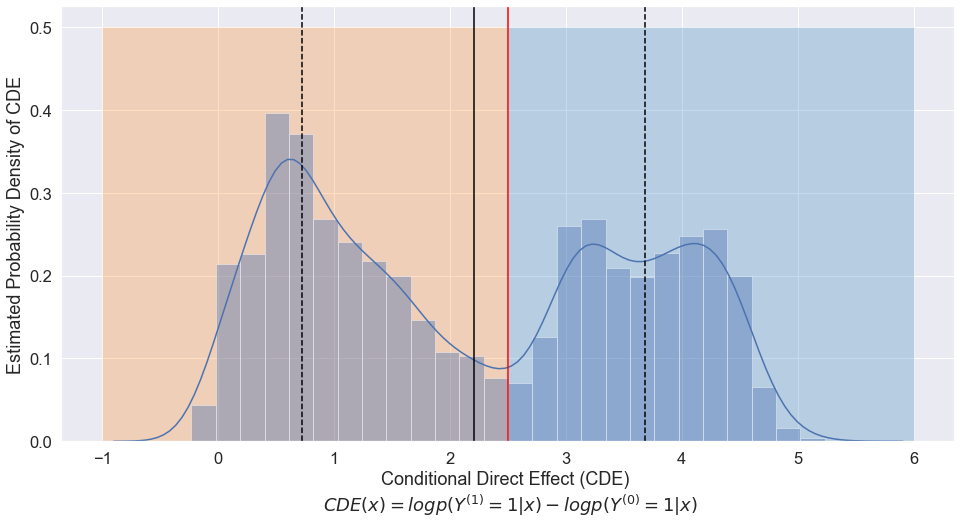

In [24]:
fig = plt.figure(figsize=(16,8))
sns.distplot(CDE)
plt.axvline(2.5,c='red')
plt.axvline(np.mean(CDE),c='black')
plt.axvline(np.mean(CDE)-np.std(CDE),ls='--',c='black')
plt.axvline(np.mean(CDE)+np.std(CDE),ls='--',c='black')
plt.fill_between(np.linspace(-1,2.5,50), 0, 0.5,facecolor='#ff7f0e', alpha=0.25)
plt.fill_between(np.linspace(2.5,6,50), 0, 0.5,facecolor='#1f77b4', alpha=0.25)
plt.xlabel('Conditional Direct Effect (CDE) \n $CDE(x) = logp(Y^{(1)}=1|x) - logp(Y^{(0)}=1|x)$')
plt.ylabel('Estimated Probability Density of CDE')

Text(0.5, 1.0, 'Who is Benefitted by participating in SHG/Saving Group?\n(Blue => Benefitted; Orange => Not Benefitted)')

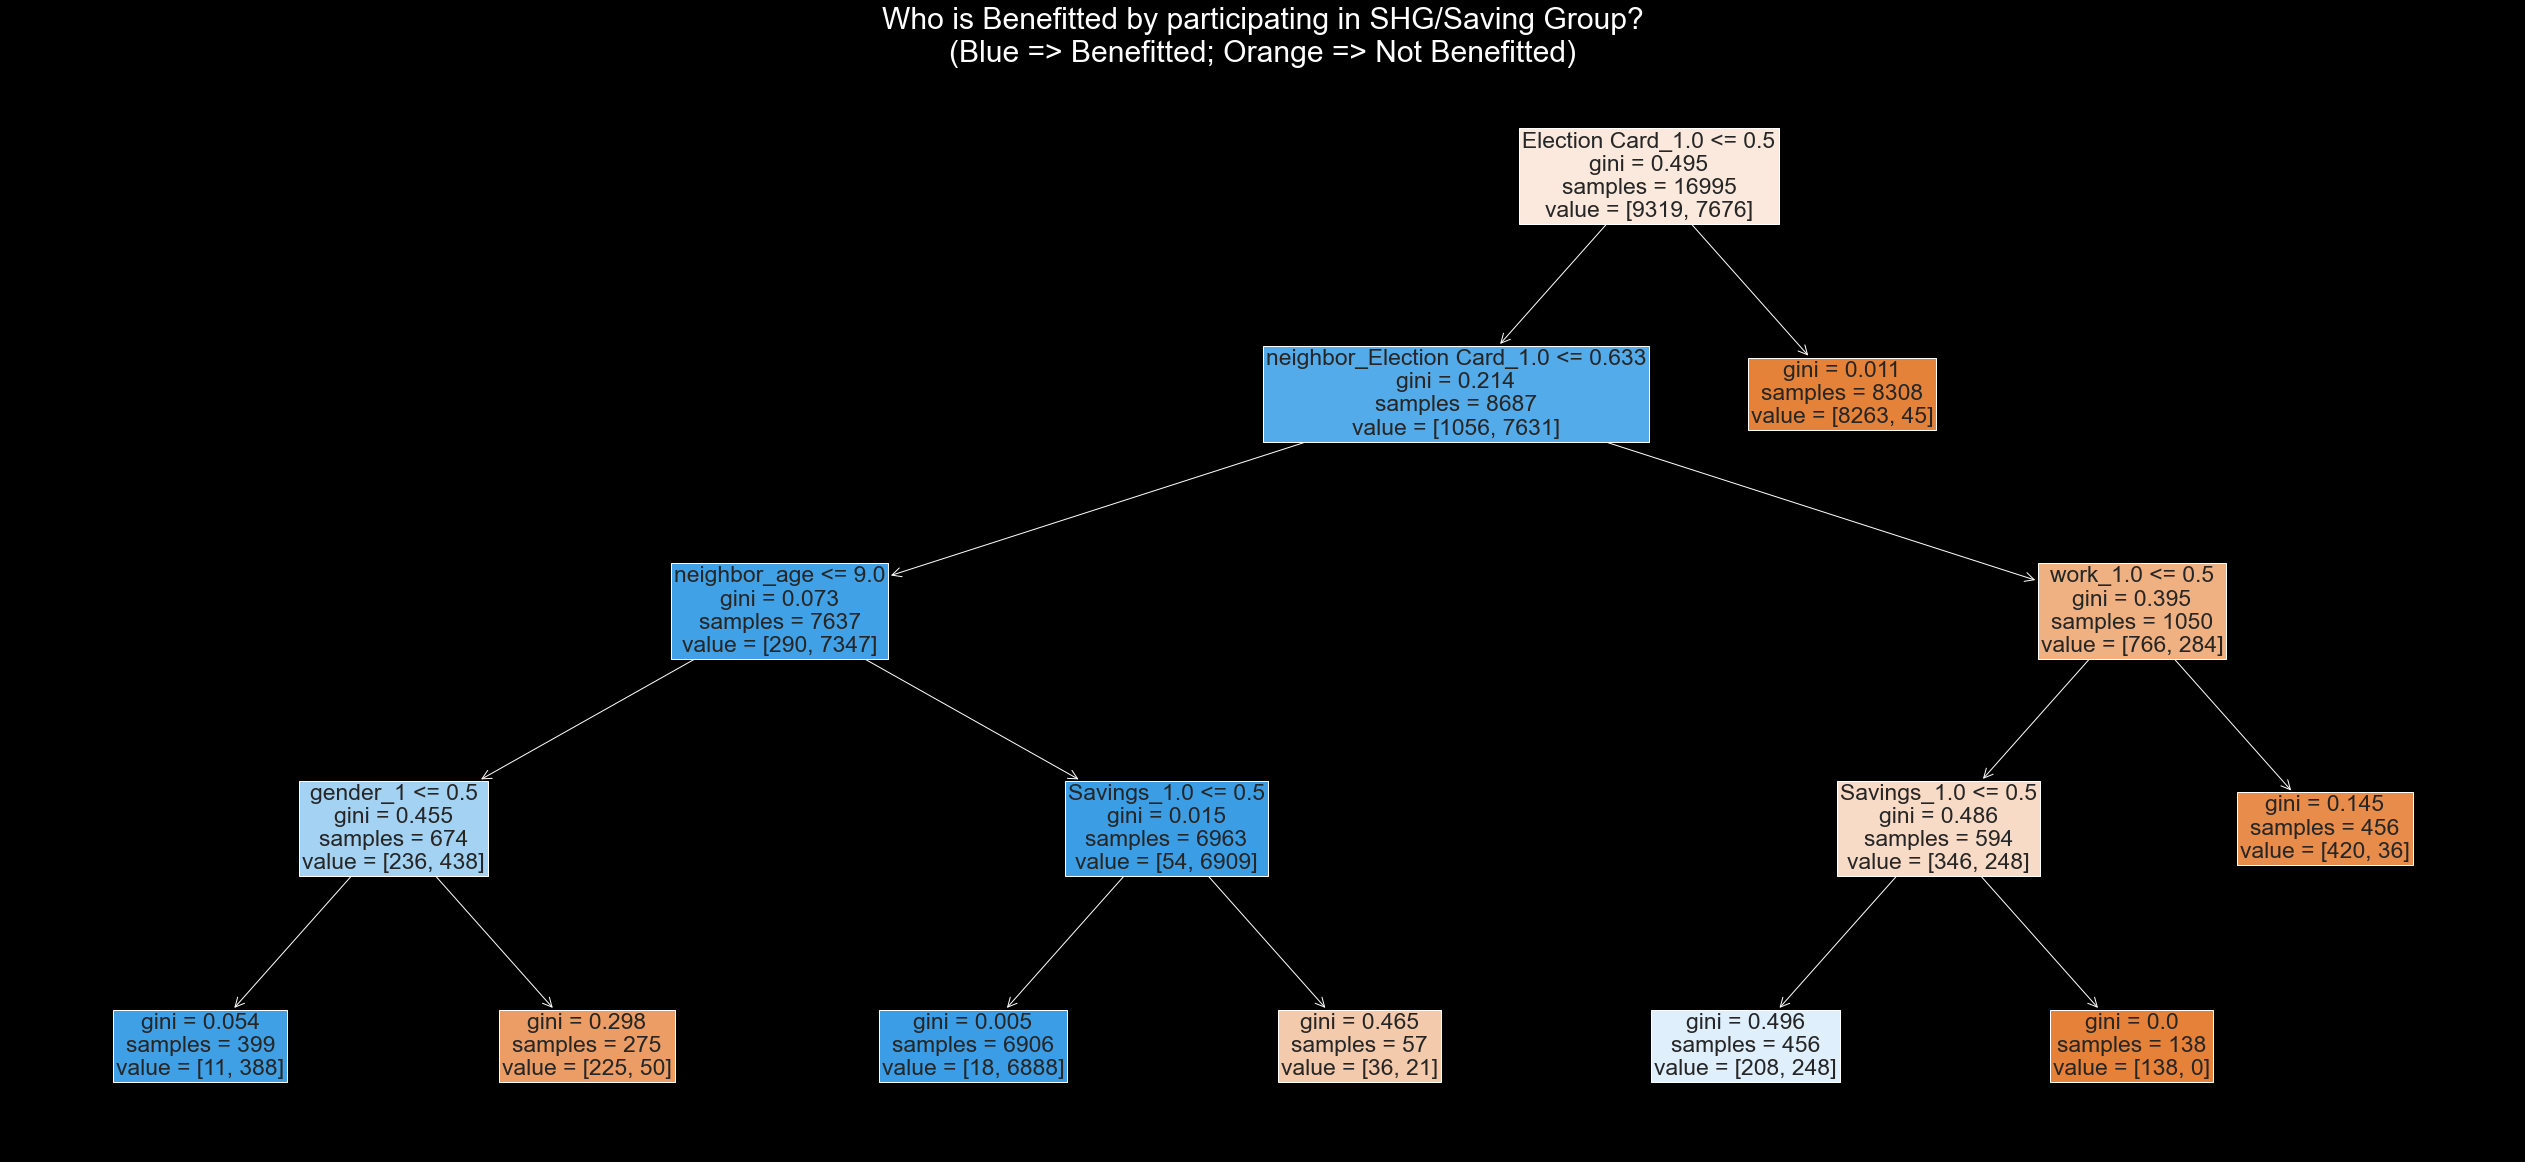

In [25]:
model_hetero = tree.DecisionTreeClassifier(max_leaf_nodes=8).fit(X,CDE>(2.5))
model_hetero.score(X,CDE>(2.5))
sns.set(font_scale=2.5)
fig = plt.figure(figsize=(45,20),facecolor='black')
tree.plot_tree(model_hetero,feature_names=X.columns,filled=True)
plt.title('Who is Benefitted by participating in SHG/Saving Group?\n(Blue => Benefitted; Orange => Not Benefitted)',color='white')

# Hypothesis Testing for Effect Modifiers

In [19]:
def summarize(df):
    df2 = df.rename(columns={c:'neighbor_'+c for c in df.columns})
    sr = df2.mean(axis=0)
    return sr

from tqdm import tqdm
def contains(G,H,j):
    ## is H contained in G?
    A = G
    GM = nx.algorithms.isomorphism.GraphMatcher(A,H)
    is_isomorphic = int(GM.subgraph_is_isomorphic())
    return is_isomorphic

#     if is_isomorphic:
#         GM_1 = nx.algorithms.isomorphism.ISMAGS(H,A)
#         iso_lst = list(GM_1.largest_common_subgraph())
#         for iso in iso_lst:
#             if (j in iso) and (len(iso)==len(H.nodes())):
# #                 print(iso[j])
#                 if (iso[j] == list(A.nodes())[0]):
#                     return 1
#     return 0

def get_first_order_egocentric_graph(G,i):
    Ai = G.loc[i]
#     print(np.where(Ai==1)[0])
    idx = [i]+list(Ai.loc[Ai>0].index)
    A_ego = G.loc[idx][idx]
    return A_ego

def get_x_u(V,X):
    return V[X]

def get_delta_u(G,Delta,Delta_col,idxs):
    df = pd.DataFrame()
    for i in (idxs):
        Gi = get_first_order_egocentric_graph(G,i)
        Gi1 = Gi.to_numpy()
        u_i = pd.DataFrame(np.array([ contains(nx.from_numpy_array(Gi1),delta[0],delta[1]) for delta in Delta]).reshape(1,-1),index=[i],columns=Delta_col)
        df = df.append(u_i)
    return df

def get_u(G,V,X,Delta,Delta_col):
    df_delta = get_delta_u(G,Delta,Delta_col)
    df_x = get_x_u(V,X)
    df = df_x.join(df_delta)
    return df

def fit(U,tau):
    X_train, X_test, y_train, y_test = train_test_split(U, tau, test_size=0.5, random_state=42)
    model = tree.DecisionTreeClassifier().fit(X_train,y_train)
    return model#, model.predict_proba(U,tau)

def set_data(outcome, treatment, df_unit, df_social_net, hypothesis):
    # adjacency list to adjacency matrix
    social = pd.DataFrame(np.zeros((df_unit.shape[0],df_unit.shape[0])),index=df_unit.index,columns=df_unit.index)
    for idx in tqdm(df_social_net.index):
        adj_list = set(df_social_net.loc[idx])
        for n in adj_list:
            try:
                if n!='0':
                    social.loc[idx,n] = social.loc[idx,n]+1
                    social.loc[n,idx] = social.loc[n,idx]+1
            except:
                continue
    social_b = (social>0).astype(int)
    
    # summarizing neighbors covariates 
    data_w_neighbor_cov = pd.DataFrame()
    idxs = set(df_unit.index)
    for idx in tqdm(idxs):
        n_idxs = np.unique(df_social_net.loc[idx])
        n_idxs = set(np.delete(n_idxs, np.where(n_idxs == '0')))
        n_idxs = n_idxs.intersection(idxs)
        sr = summarize(df_unit.loc[n_idxs])
        df2 = pd.DataFrame(df_unit.loc[idx].append(sr),columns=[idx]).T
        data_w_neighbor_cov = data_w_neighbor_cov.append(df2)
    
    #adding network pattern to data
    idxs = data_w_neighbor_cov.dropna().index
    sample_data = data_w_neighbor_cov.loc[idxs]

    Delta = hypothesis['Delta'] 
    Delta_col = hypothesis['Delta_col'] 

    df_delta = get_delta_u(social_b,Delta,Delta_col,idxs=idxs)
    sample_w_netstruct = sample_data.join(df_delta,how='inner')
    
    #estimating CDE and ADE
    Y = sample_w_netstruct[outcome].fillna(0)
    T = sample_w_netstruct[treatment].fillna(0)
    X = sample_w_netstruct.fillna(0)
    return X,Y,T

def get_cde(X,Y,T):
    model_c = lm.LogisticRegressionCV().fit(X.loc[T==0.0],Y.loc[T==0.0])
    model_t = lm.LogisticRegressionCV().fit(X.loc[T==1.0],Y.loc[T==1.0])

    CDE = (model_t.predict_log_proba(X)[:,1] - model_c.predict_log_proba(X)[:,1])
    df_CDE = pd.DataFrame(CDE,index=X.index,columns=['TE'])
    ADE = np.mean(CDE)
    print(ADE)
    print((ADE-2*np.std(CDE),ADE+2*np.std(CDE)))
    
    fig = plt.figure(figsize=(16,8))
    sns.distplot(CDE)
    plt.axvline(np.mean(CDE),c='black')
    plt.axvline(np.mean(CDE)-2*np.std(CDE),ls='--',c='black')
    plt.axvline(np.mean(CDE)+2*np.std(CDE),ls='--',c='black')
    plt.xlabel('Conditional Direct Effect (CDE) \n $CDE(x) = E(Y^{(1)}|x,n,g) - E(Y^{(0)}|x,n,g)$')
    plt.ylabel('Estimated Probability Density of CDE')
    plt.savefig('CDE.png')
    
    return X,Y,T,CDE,ADE
    
def test_heterogeneity(X,Y,T,CDE,ADE,hypothesis, sample_size=1000,discrete={},predictor='AdaBoost'):

    # Posterior Projecting CDE on Hypothesis Space
    estimator_f = {}
    Q = {}
    H = X[list(hypothesis['X_col']) + list(hypothesis['Delta_col'])]
    for col in tqdm(H.columns):      
        samples = sample_size
        x_range = np.min(H[[col]]),np.max(H[[col]])
        X1 = np.sort(H[[col]].to_numpy(),axis=0)
#         if col in discrete:
#             X1 = np.arange(int(x_range[0]),int(x_range[1]+1)).reshape(-1,1)
#         else:
#             X1 = np.linspace(x_range[0],x_range[1],num=samples).reshape(-1,1)
        
        if predictor=='SVM':
            model = svm.SVR().fit(H[[col]],CDE)
            se = np.sqrt(np.mean(np.square(CDE - model.predict(H[[col]]))))
            print(model.score(H[[col]],CDE))

            y_hat_mean = model.predict(X1)
            y_hat_std = np.ones_like(y_hat_mean)*se

            estimator_f[col] = [model]
            
        if predictor=='AdaBoost':
            additive_model = ensemble.AdaBoostRegressor().fit(H[[col]],CDE)
            estimators = additive_model.estimators_
            y_hat_array = []
            for i in range(len(estimators)):
                estimator = estimators[i]
                y_hat = estimator.predict(X1)
                y_hat_array.append(y_hat)
                if col not in estimator_f:
                    estimator_f[col] = []
                estimator_f[col] = estimator_f[col] + [estimator]
            y_hat_array = np.array(y_hat_array)
            y_hat_mean = np.mean(y_hat_array,axis=0)
            y_hat_std = np.std(y_hat_array,axis=0)
        
        if predictor=='GradientBoosting':
            alpha = 0.95
            upper = ensemble.GradientBoostingRegressor(loss='quantile', alpha=alpha,n_estimators=10000,max_leaf_nodes=64).fit(H[[col]],CDE)
            lower = ensemble.GradientBoostingRegressor(loss='quantile', alpha=1.0-alpha,n_estimators=10000,max_leaf_nodes=64).fit(H[[col]],CDE)
            mean_model = svm.SVR().fit(H[[col]],CDE) #ensemble.RandomForestRegressor(n_estimators=100).fit(H[[col]],CDE)
            y_hat_mean = mean_model.predict(X1)
            y_hat_std = np.abs(upper.predict(X1) - lower.predict(X1))/4.0
        
        if predictor == 'BayesianRidge':
            model = lm.BayesianRidge().fit(H[[col]],CDE)
            y_hat_mean, y_hat_std = model.predict(X1, return_std=True)
            estimator_f[col] = [model]
            
        if predictor == 'GaussianProcess':
            kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, np.std(CDE)))
            model = gp.GaussianProcessRegressor(kernel=kernel, normalize_y=True).fit(H[[col]],CDE)
            y_hat_mean, y_hat_std = model.predict(X1, return_std=True)
            estimator_f[col] = [model]


        Q[col] = np.mean(((y_hat_mean - ADE)**2)/y_hat_std)
        H['CDE'] = CDE
        fig = plt.figure(figsize=(10,8))
        if col in discrete:
            if predictor == 'AdaBoost':
                for j_col in range(X1.shape[0]):
                    plt.boxplot(y_hat_array[:,j_col],positions=[j_col])
#             sns.boxplot(x=col,y='CDE',data=H,boxprops=dict(alpha=.15))
            else:
                plt.errorbar(X1,y_hat_mean,yerr=y_hat_std,elinewidth=30,fmt='.k',capsize=0,alpha=0.3,ecolor='gray')
                plt.errorbar(X1,y_hat_mean,yerr=2*y_hat_std,elinewidth=2,fmt='.k',capsize=12,ecolor='black')
#             plt.scatter(X1,y_hat_mean)
        else:
#             sns.scatterplot(x=col,y='CDE',data=H,alpha=0.1)
            plt.plot(X1,y_hat_mean,linewidth=3,c='black')
            plt.fill_between(X1[:,0], y1=y_hat_mean+2*y_hat_std, y2=y_hat_mean-2*y_hat_std,alpha=0.25)
        plt.xlabel(str(col))
        plt.ylabel('E[CDE|%s]'%(col))
        plt.axhline(0,c='red')
        fig.savefig('adaBoost_f_%s.png'%(col))
    
    return df_CDE,ADE,estimator_f,Q,H

In [20]:
outcome = 'Loan_1.0'
treatment = 'SHG/saving group_1.0'

df_unit = survey_data_dummified.drop(columns=['hhid',
                                      'village_10','village_11','village_12','village_14','village_15','village_16',
                                      'village_17','village_18','village_19','village_2','village_20','village_21',
                                      'village_23','village_24','village_25','village_26','village_27','village_28',
                                      'village_29','village_3','village_30','village_31','village_32','village_33',
                                      'village_34', 'village_35','village_36','village_37','village_38','village_39',
                                      'village_4','village_40','village_41','village_42','village_43','village_44',
                                      'village_45','village_46','village_47','village_48','village_49','village_5',
                                      'village_50','village_51','village_52','village_53','village_54','village_55',
                                      'village_56','village_57','village_58','village_59','village_6','village_60',
                                      'village_61','village_62','village_63','village_64','village_65','village_66',
                                      'village_67','village_68','village_69','village_7','village_70','village_71',
                                      'village_72','village_73','village_74','village_75','village_76','village_77',
                                      'village_8','village_9']).fillna(0)

network_of_interest = ['nonrel','visitcome','visitgo','templecompany','rel','lendmoney','keroricecome']
df_social_net = networks['rel'].drop(columns=['village'])
for net_type in network_of_interest:
    df_social_net = df_social_net.join(networks[net_type].drop(columns=['village']),how='outer',rsuffix='r').fillna(0)
    

hypothesis = {}
hypothesis['Delta'] = [(nx.complete_graph(3),0),(nx.complete_graph(4),0),(nx.complete_graph(5),0),(nx.complete_graph(6),0)]
hypothesis['Delta_col'] = ['Clique-3','Clique-4','Clique-5','Clique-6']
hypothesis['X_col'] = ['age', 'education','Savings_1.0','Election Card_1.0','neighbor_Election Card_1.0','neighbor_Savings_1.0',
                       'Ration Card Color_2.0','gender_1']#list(df_unit.drop(columns = [outcome,treatment]).columns)

In [21]:
X,Y,T = set_data(outcome, treatment, df_unit, df_social_net, hypothesis)

100%|██████████| 16995/16995 [02:55<00:00, 96.96it/s] 


2.190362105928565
(-0.4804833930623067, 4.861207604919437)


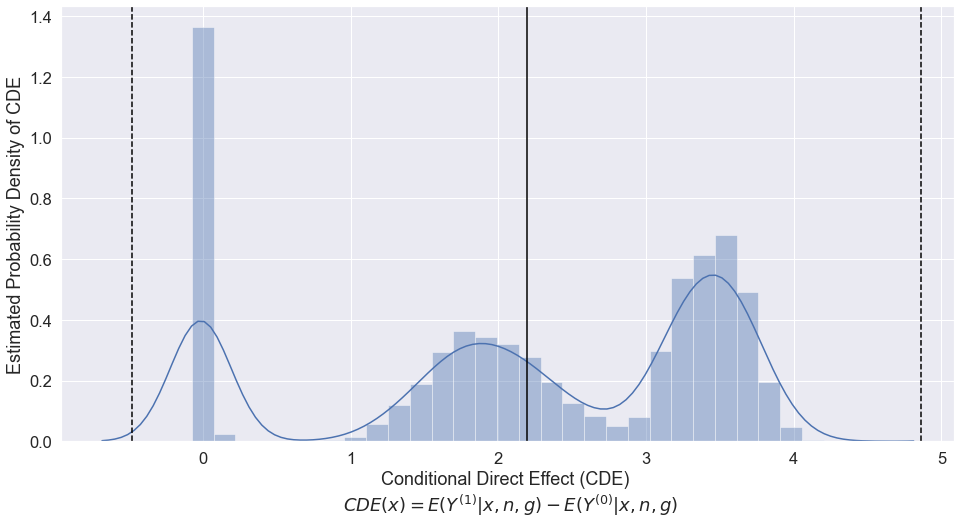

In [22]:
X,Y,T,CDE,ADE = get_cde(X,Y,T)

  0%|          | 0/12 [00:00<?, ?it/s]

0.005254864630830135


  8%|▊         | 1/12 [00:18<03:26, 18.80s/it]

-0.011609242129229091


 17%|█▋        | 2/12 [00:38<03:11, 19.19s/it]

0.16515656895852204


 25%|██▌       | 3/12 [00:57<02:52, 19.14s/it]

0.5468013968424197


 33%|███▎      | 4/12 [01:19<02:39, 19.98s/it]

0.6183623448520386


 42%|████▏     | 5/12 [01:38<02:16, 19.48s/it]

0.422991213090115


 50%|█████     | 6/12 [01:56<01:54, 19.09s/it]

-0.002077489238320407


 58%|█████▊    | 7/12 [02:15<01:36, 19.21s/it]

0.02102128702797501


 67%|██████▋   | 8/12 [02:40<01:22, 20.74s/it]

-0.009216593512600957


 75%|███████▌  | 9/12 [02:58<01:00, 20.09s/it]

-0.007569728820748578


 83%|████████▎ | 10/12 [03:22<00:42, 21.17s/it]

-0.006398611711693203


 92%|█████████▏| 11/12 [03:39<00:19, 19.90s/it]

-0.007317056057483784


100%|██████████| 12/12 [03:54<00:00, 19.52s/it]


NameError: name 'df_CDE' is not defined

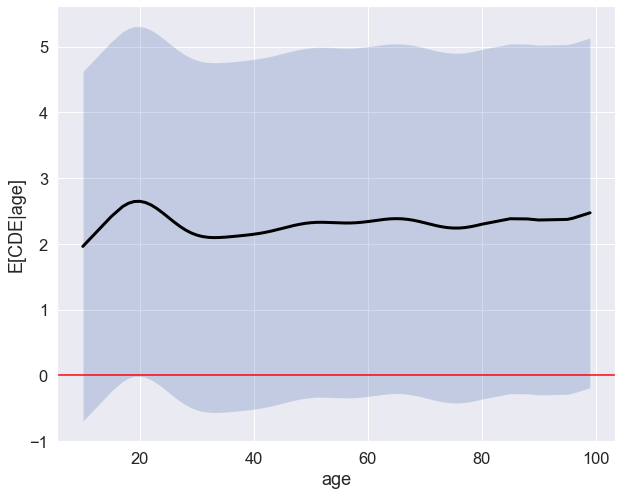

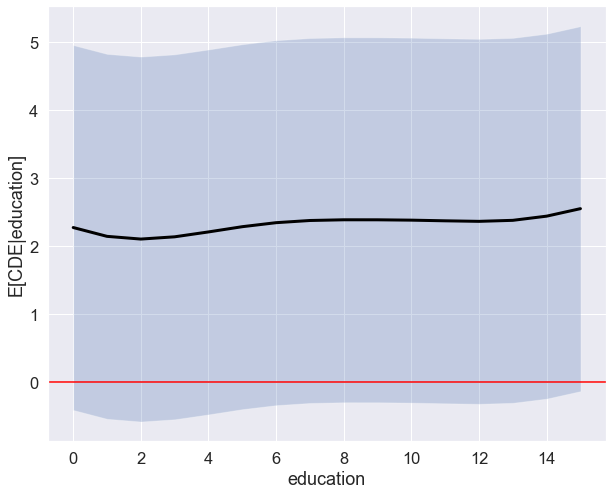

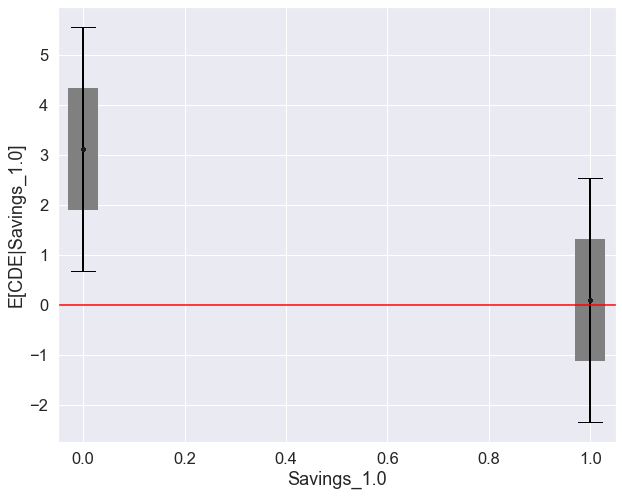

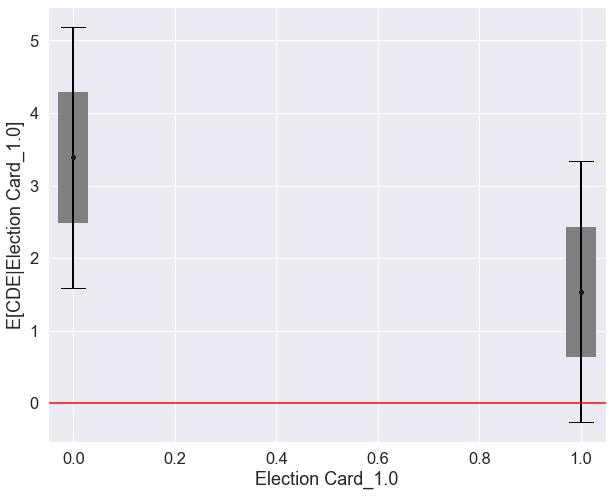

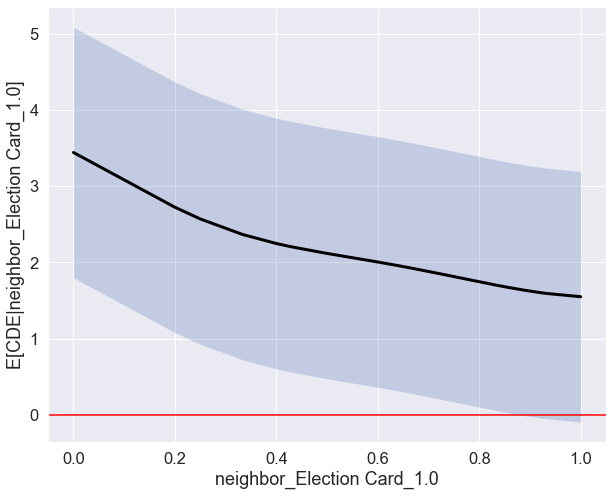

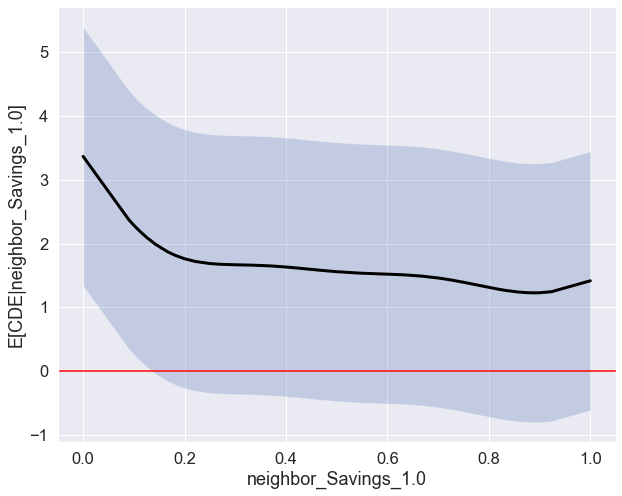

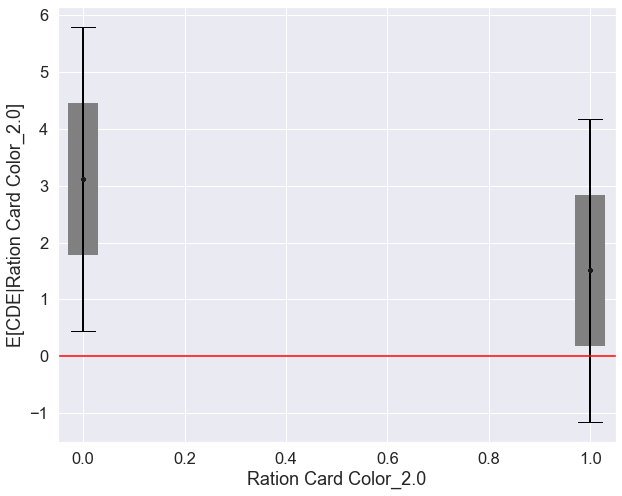

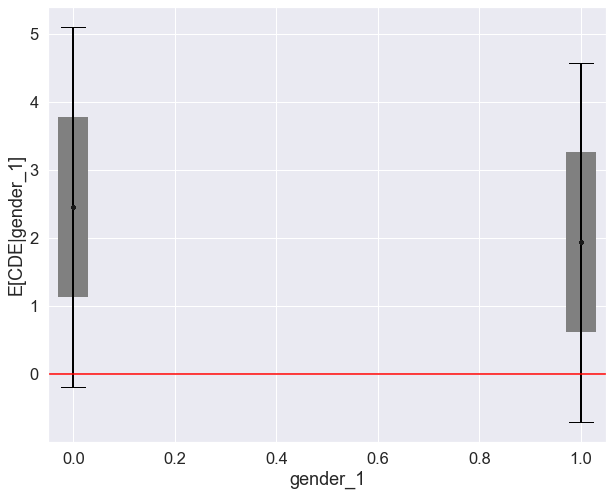

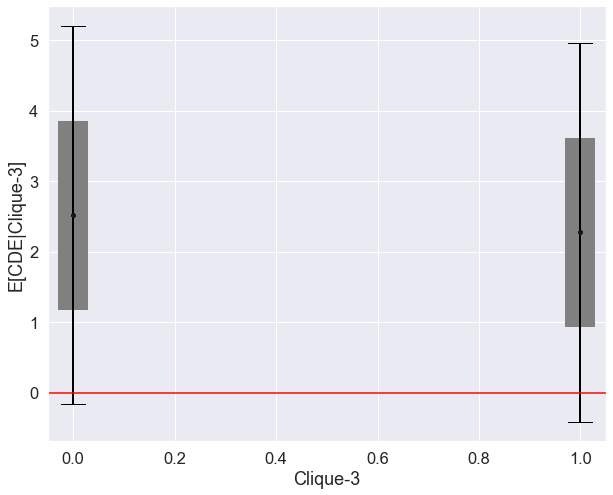

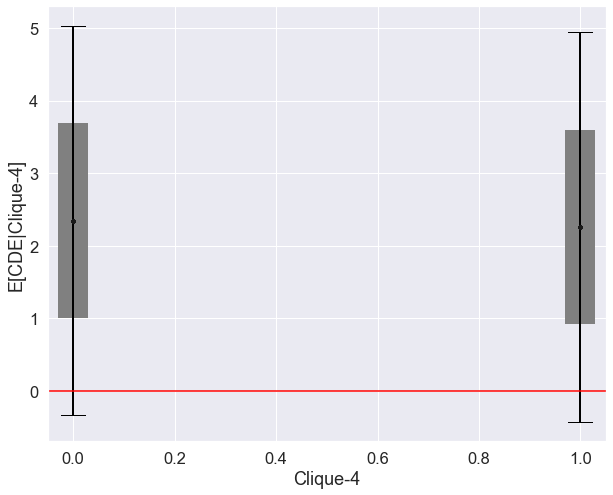

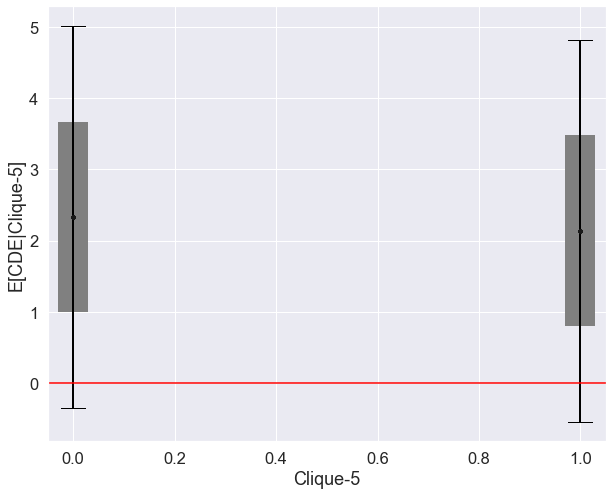

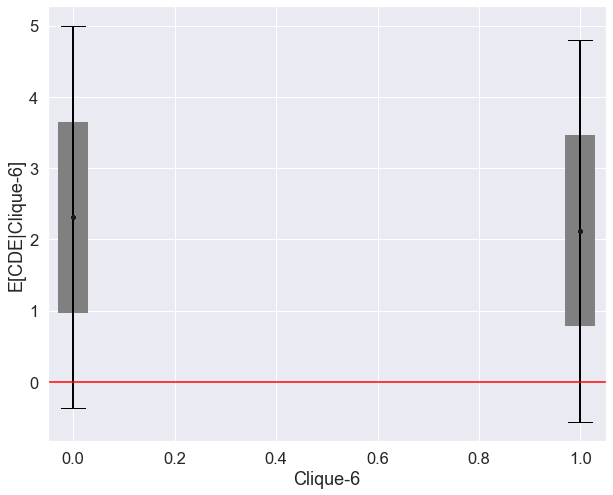

In [23]:
k = 1000
discrete = ['Savings_1.0','Election Card_1.0','Ration Card Color_2.0','gender_1','Clique-3','Clique-4','Clique-5','Clique-6']
df_CDE,ADE,estimator_f,Q,H  = test_heterogeneity(X,Y,T,CDE,ADE,hypothesis, sample_size=k,discrete=discrete,predictor='SVM')

In [33]:
df = np.array([1 if key not in discrete else 1 for key in Q.keys()]).reshape(-1,1)
df_test = pd.DataFrame.from_dict(Q,orient='index',columns=['Q'])
df_test['I2'] = np.abs(pd.DataFrame((100*(df_test[['Q']].to_numpy()-df)/df_test[['Q']].to_numpy())*((df_test[['Q']].to_numpy()-df)>0),index=Q.keys()))
df_test['df'] = df

In [36]:
print(df_test.drop(columns=['df']).to_latex())

\begin{tabular}{lrr}
\toprule
{} &         Q &         I2 \\
\midrule
age                        &  0.032416 &   0.000000 \\
education                  &  0.023230 &   0.000000 \\
Savings\_1.0                &  2.509370 &  60.149355 \\
Election Card\_1.0          &  2.053378 &  51.299764 \\
neighbor\_Election Card\_1.0 &  3.941499 &  74.628940 \\
neighbor\_Savings\_1.0       &  1.100815 &   9.158221 \\
Ration Card Color\_2.0      &  0.883201 &   0.000000 \\
gender\_1                   &  0.075762 &   0.000000 \\
Clique-3                   &  0.025934 &   0.000000 \\
Clique-4                   &  0.018117 &   0.000000 \\
Clique-5                   &  0.019835 &   0.000000 \\
Clique-6                   &  0.015666 &   0.000000 \\
\bottomrule
\end{tabular}

